In [1]:
# 1. Import all necessary libraries
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\tered\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 2. Define paths
raw_path = r"C:\Users\tered\Desktop\recommender_system\data\raw\english_books.csv"
processed_path = r"C:\Users\tered\Desktop\recommender_system\data\processed\books_synopsis_clean.csv"
experiment_path = r"C:\Users\tered\Desktop\recommender_system\experiments\05_sbert_kmeans_synopsis"
os.makedirs(experiment_path, exist_ok=True)

In [3]:
# 3. Load raw dataset
df = pd.read_csv(raw_path)

In [4]:
# 4. Rename 'description' to 'synopsis'
df.rename(columns={"description": "synopsis"}, inplace=True)

# 5. Clean the data: remove rows with missing synopsis or title
initial_count = len(df)
df_clean = df.dropna(subset=["title", "synopsis"])
final_count = len(df_clean)
removed_count = initial_count - final_count
df_clean.reset_index(drop=True, inplace=True)

# 6. Save the cleaned dataset
df_clean.to_csv(processed_path, index=False)
print(f"✅ Cleaned dataset saved at: {processed_path}")
print(f"🟢 Total rows before cleaning: {initial_count}")
print(f"🟢 Total rows after cleaning:  {final_count}")
print(f"🔴 Rows removed:              {removed_count}")

✅ Cleaned dataset saved at: C:\Users\tered\Desktop\recommender_system\data\processed\books_synopsis_clean.csv
🟢 Total rows before cleaning: 6810
🟢 Total rows after cleaning:  6548
🔴 Rows removed:              262


In [5]:
# 7. Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 8. Encode the synopses using SBERT
embeddings = model.encode(df_clean['synopsis'].tolist(), show_progress_bar=True)

# 9. Apply KMeans clustering
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

# Add cluster labels to dataframe
df_clean["cluster"] = labels


Batches: 100%|██████████| 205/205 [17:48<00:00,  5.21s/it]
C:\Users\tered\AppData\Local\Temp\ipykernel_8472\1688341851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["cluster"] = labels


In [7]:
# 10. Silhouette Score (puede seguir siendo lento, opcionalmente usa una muestra)
sample_size = 2000  # ajusta según recursos
if len(embeddings) > sample_size:
    from sklearn.utils import resample
    sampled_embeddings, sampled_labels = resample(embeddings, labels, n_samples=sample_size, random_state=42)
    sil_score = silhouette_score(sampled_embeddings, sampled_labels)
else:
    sil_score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0178


In [8]:
# 11. Cosine Similarity Matrix (una vez, vectorizado)
cos_sim_matrix = cosine_similarity(embeddings)

In [9]:
# 12. Average Cosine Similarity (vectorizado)
upper_tri = cos_sim_matrix[np.triu_indices(len(embeddings), k=1)]
avg_cos_sim = np.mean(upper_tri)
print(f"Average Cosine Similarity: {avg_cos_sim:.4f}")

Average Cosine Similarity: 0.1511


In [10]:
# 13. Intra-list Diversity (opcional: limitar clusters grandes)
def calculate_intra_list_diversity(df, embeddings, label_col='cluster', max_cluster_size=1000):
    diversities = []
    for cluster_id in df[label_col].unique():
        indices = df[df[label_col] == cluster_id].index
        if len(indices) < 2:
            continue
        if len(indices) > max_cluster_size:
            indices = np.random.choice(indices, max_cluster_size, replace=False)
        emb_subset = embeddings[indices]
        sim_matrix = cosine_similarity(emb_subset)
        upper_tri = sim_matrix[np.triu_indices(len(sim_matrix), k=1)]
        diversity = 1 - np.mean(upper_tri)
        diversities.append(diversity)
    return np.mean(diversities)

intra_diversity = calculate_intra_list_diversity(df_clean, embeddings)
print(f"Intra-list Diversity: {intra_diversity:.4f}")

Intra-list Diversity: 0.7456


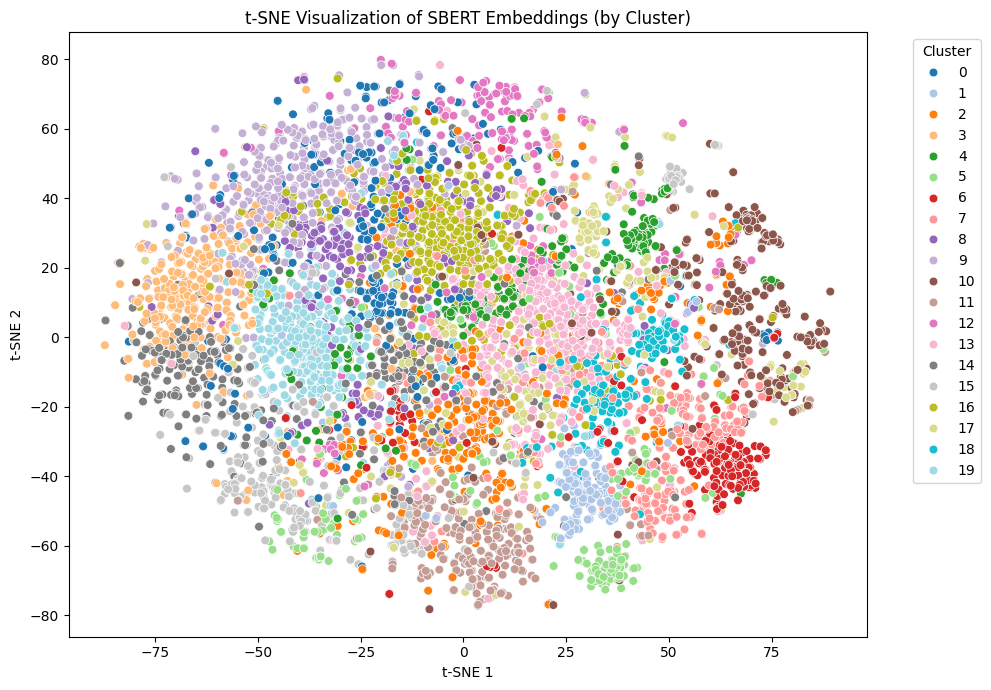

In [11]:
# 14. t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(embeddings)

# 15. Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df_clean["cluster"], palette="tab20", s=40)
plt.title("t-SNE Visualization of SBERT Embeddings (by Cluster)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(experiment_path, "tsne_clusters.png"))
plt.show()


In [15]:
# 16. Recommendation for book index 2676
book_idx = 2632
selected_embedding = embeddings[book_idx].reshape(1, -1)

# Compute similarity with all books
similarities = cosine_similarity(selected_embedding, embeddings)[0]

# Get Top 10 (excluding the book itself)
top_indices = similarities.argsort()[::-1][1:11]
print(f"\nFinding recommendations for book index: {book_idx}")
print(f"\nSelected book [{book_idx}]: {df_clean.loc[book_idx, 'title']}")
print("\nTop 10 Recommendations based on SBERT + Cosine Similarity:\n")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. [{idx}] {df_clean.loc[idx, 'title']} (Similarity: {similarities[idx]:.4f})")



Finding recommendations for book index: 2632

Selected book [2632]: Harry Potter and the Prisoner of Azkaban (Book 3)

Top 10 Recommendations based on SBERT + Cosine Similarity:

1. [2620] Harry Potter and the Sorcerer's Stone (Book 1) (Similarity: 0.6480)
2. [2583] Harry Potter and the Chamber of Secrets (Book 2) (Similarity: 0.5682)
3. [2598] Harry Potter and the Order of the Phoenix (Book 5) (Similarity: 0.5571)
4. [2645] Harry Potter and the Half-Blood Prince (Book 6) (Similarity: 0.5125)
5. [4375] Harry Potter and the Prisoner of Azkaban (Similarity: 0.4902)
6. [2619] Harry Potter and the Chamber of Secrets (Similarity: 0.4821)
7. [238] Son of a Witch (Similarity: 0.4812)
8. [4358] Harry Potter and the Goblet of Fire (Similarity: 0.4809)
9. [2160] Exile's Return (Similarity: 0.4692)
10. [2652] The Harry Potter Collection (Similarity: 0.4685)
